# X-Ray Image Labelling & Reporting
**`Team AKAKI!` | `Minerva University`**

---

## Project Overview

In summary, we are measuring the similarity of predicted captions to the actual captions provided by doctors.

This is broken down into multiple steps:
- Clean Indiana X-Ray imaging data.
- Explore ways to increase and engineer features for better results.
- Use machine learning, NLP, computer vision, and other methods to label the chest X-Rays.
- Compare the labels we generate against the actual label provided by the doctors.

For example,
- **Real Caption:** the lungs are hyperinflated with coarse interstitial markings compatible with obstructive pulmonary disease and emphysema periodseq there is chronic pleuralparenchymal scarring within the lung bases periodseq no lobar consolidation is seen periodseq no pleural effusion or pneumothorax periodseq heart size is normal period.
- **Prediction Caption:** typical findings of pulmonary consolidation periodseq no pneumothorax periodseq there is no evidence for effusion.

---

## Import Libraries and Data

In [ ]:
# import libraries
import pandas as pd
import string
import contractions
import matplotlib.pyplot as plt
from cleantext import clean
from sklearn.model_selection import train_test_split

from glob import glob

!ls /datasets/gdrive/XRay-AKAKI

images_normalized	 indiana_reports.csv
indiana_projections.csv  radiology_vocabulary_final.xlsx


In [ ]:
# projections = pd.read_csv("/datasets/gdrive/XRay-AKAKI/indiana_projections.csv")
# print(projections.shape[0])
# projections.head()

In [ ]:
# reports = pd.read_csv("/datasets/gdrive/XRay-AKAKI/indiana_reports.csv")
# print(reports.shape[0])
# reports.head()

In [ ]:
# # Concatenates both tables using the uid as primary
# data = pd.merge(reports, projections, how="left", on="uid")
# print(data.shape[0])
# data

# #Write the dataset to a csv file
#data.to_csv('../data/raw/raw_merged_xray_data.csv', index=False)

In [ ]:
data = pd.read_csv('../data/raw/raw_merged_xray_data.csv')

In [ ]:
# defines image path
images_path = "/datasets/gdrive/XRay-AKAKI/images_normalized"

# Use glob to grab images from path .jpg or jpeg
images_file_names = glob(images_path + '/*')

print(len(images_file_names))

7693


In [ ]:
data

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-4001.dcm.png,Frontal
1,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-3001.dcm.png,Lateral
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-1001.dcm.png,Frontal
3,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-2001.dcm.png,Lateral
4,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",3_IM-1384-1001.dcm.png,Frontal
...,...,...,...,...,...,...,...,...,...,...
7461,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB.",3997_IM-2048-1002.dcm.png,Lateral
7462,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.,3998_IM-2048-1001.dcm.png,Frontal
7463,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.,3998_IM-2048-1002.dcm.png,Lateral
7464,3999,normal,normal,"CHEST PA and LATERAL: on XXXX, XXXX.",This is a XXXX-year-old female patient with sh...,"Chest x-XXXX, XXXX, XXXX.",NaN,The cardiac silhouette is normal in size and c...,3999_IM-2049-1001.dcm.png,Frontal


In [ ]:
images_file_names[0:5]

['/datasets/gdrive/XRay-AKAKI/images_normalized/1058_IM-0041-2001.dcm.png.npy',
 '/datasets/gdrive/XRay-AKAKI/images_normalized/1059_IM-0041-1001.dcm.png.npy',
 '/datasets/gdrive/XRay-AKAKI/images_normalized/105_IM-0037-1001.dcm.png.npy',
 '/datasets/gdrive/XRay-AKAKI/images_normalized/105_IM-0037-2001.dcm.png.npy',
 '/datasets/gdrive/XRay-AKAKI/images_normalized/1060_IM-0042-1001.dcm.png.npy']

In [ ]:
# see distinct values in image column
data['image'].unique()

array(['Xray Chest PA and Lateral', 'Chest, 2 views, frontal and lateral',
       'PA and lateral views of the chest XXXX, XXXX at XXXX hours ',
       'PA and Lateral Chest. XXXX, XXXX at XXXX ',
       'PA and lateral chest x-XXXX XXXX. ',
       'PA and lateral chest radiograph (2 views) (2 images) ',
       'Chest, 2 views, XXXX XXXX ComparisXXXX/XXXX ',
       'PA and lateral views of the chest dated XXXX. ',
       'PA and LAT view CHEST XXXX, XXXX XXXX PM',
       'PA and lateral chest radiograph, XXXX at XXXX hours. ',
       '2 VIEW CHEST: XXXX, XXXX at XXXX hours.',
       'PA AND LATERAL VIEWS OF THE CHEST dated XXXX XXXX hours ',
       'Chest x-XXXX XXXX and lateral, XXXX ',
       'PA and lateral views of the Chest performed XXXX/XXXX.',
       'PA and lateral chest radiographs XXXX at XXXX hours. ',
       'PA and lateral chest x-XXXX dated XXXX, XXXX at XXXX p.m.. ',
       'Chest x-XXXX XXXX ',
       ' CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM ',
       'PA and late

In [ ]:
# see distinct values in comparison column
data['comparison'].unique()

array(['None.', nan, 'None available', 'XXXX, XXXX',
       'Two views of the chest dated XXXX.',
       'CT XXXX image XXXX, CT abdomen which included the lower thorax XXXX.',
       'Chest radiographs XXXX.', 'None',
       'Chest radiograph from XXXX, XXXX.',
       'XXXX films of the chest dated XXXX.',
       'CT chest angiography, XXXX', 'PA lateral chest radiograph, XXXX.',
       'PA and lateral chest XXXX and CTA XXXX.', 'XXXX',
       'Portable chest dated XXXX.', 'Comparison XXXX, XXXX.',
       'PA and lateral chest redressed XXXX',
       'Two-view chest radiograph dated XXXX, XXXX..', 'XXXX, XXXX.',
       'PA and lateral views of the chest from XXXX.',
       'Comparison is XXXX to chest radiograph examination dated XXXX.',
       'None available.', 'Radiograph Chest PA and Lateral XXXX, XXXX.',
       'Chest 2 views from XXXX, XXXX. .',
       'PA and lateral views of the chest on XXXX, XXXX.',
       'Chest radiograph XXXX/XXXX.', 'None. Clinical', 'XXXX.',
       'PA 

In [ ]:
# see distinct values in impression column
data['impression'].unique()

array(['Normal chest x-XXXX.', 'No acute pulmonary findings.',
       'No displaced rib fractures, pneumothorax, or pleural effusion identified. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.',
       ...,
       '1. Interval resolution of bibasilar airspace disease. 2. Hyperinflation with chronic changes of emphysema. .',
       'No acute findings, no evidence for active TB.',
       'The cardiac silhouette is normal in size and configuration. The mediastinum and perihilar structures appear unremarkable. The lungs appear clear. The osseous structures are within normal limits.'],
      dtype=object)

By examining the unique values in the columns above, it helped us gather more of an understanding of what they are. These descriptions of the columns are stored in the reference.txt file.

---

## Data Cleaning & Pre-Processing

1. Drop rows with `NaN`s on both findings and impressions
2. Fuse the findings and impression columns to get richer outcome variable `caption`
3. Clean out placeholders and leading and trailing punctuation from the text
3. Split dataset on whether the X-ray is frontal or lateral view.
4. Create two different csv files (one for each view) with the data cleaned and pre-processed for reference in DeepNote.
5. Split each view as train and test to use in the model.

In [ ]:
#Drop unnecessary columns – image and comparison
#projection already tells us what type of image – so image unncessary
data_dropped_cols = data.drop(columns=['image','comparison','indication'])

#Drop rows with NaNs on both findings and impressions
data_dropped_nans = data_dropped_cols.dropna(subset=['findings','impression'], how='all')

#Append the impression to findings to make new caption column
data_dropped_nans['caption'] = data_dropped_nans[['findings','impression']].astype('str').agg(' '.join, axis=1)

print(f"Dropped {len(data)-len(data_dropped_nans)} rows from {len(data)} rows. New row count: {len(data_dropped_nans)}")

Dropped 40 rows from 7466 rows. New row count: 7426
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
data_dropped_nans.head()

,uid,MeSH,Problems,findings,impression,filename,projection,caption
0,1,normal,normal,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-4001.dcm.png,Frontal,The cardiac silhouette and mediastinum size ar...
1,1,normal,normal,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-3001.dcm.png,Lateral,The cardiac silhouette and mediastinum size ar...
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-1001.dcm.png,Frontal,Borderline cardiomegaly. Midline sternotomy XX...
3,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-2001.dcm.png,Lateral,Borderline cardiomegaly. Midline sternotomy XX...
4,3,normal,normal,NaN,"No displaced rib fractures, pneumothorax, or p...",3_IM-1384-1001.dcm.png,Frontal,"nan No displaced rib fractures, pneumothorax, ..."


### Clean out placeholders, trailing punctuations and excess whitespace

In [ ]:
### MESH AND PROBLEMS COLUMNS
#Clean MeSH and Problems
data_dropped_nans['MeSH'] = data_dropped_nans['MeSH'].str.replace('/',' ').str.replace(';',',')
data_dropped_nans['Problems'] = data_dropped_nans['Problems'].str.replace('/',' ').str.replace(';',',')

### CLEAN ALL TEXT COLUMNS EXCEPT FILENAME
cols_to_clean = ['MeSH','Problems','findings','impression','projection','caption']

#Clean out placeholders of the form xx-year-old, xxxx, x-XXX, etc.
data_dropped_nans[cols_to_clean] = data_dropped_nans[cols_to_clean].replace('[xX]+-?\s?year-?\s?old\s?([xX]+|with|w+)?\s?(with)?|[xX]+ are intact|[xX]+-[xX]+|-[xX]+|[xX]{2,}|nan', '', 
                                              regex=True)

#Remove leading and trailing commas and fullstops, etc.
data_dropped_nans[cols_to_clean] = data_dropped_nans[cols_to_clean].replace('(^[.,;/:\s]+)|([.,;/:\s]+$)', '', regex=True)

#Clear excess whitespace between words and punctuation 
data_dropped_nans[cols_to_clean] = data_dropped_nans[cols_to_clean].replace(r'\s+([,?.!;"])',r'\1', regex=True)

#Clean out left over gender with .....
data_dropped_nans[cols_to_clean] = data_dropped_nans[cols_to_clean].replace('(male|female)? with','',regex=True)

#Get rid of numbering in impression or findings
data_dropped_nans[cols_to_clean] = data_dropped_nans[cols_to_clean].replace('\d+[.]',"", regex=True)

data_dropped_nans.caption[2]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set 

'Borderline cardiomegaly. Midline sternotomy. Enlarged pulmonary arteries. Clear lungs. Inferior. No acute pulmonary findings'

### Replace missing values

In [ ]:
#If the MeSH and the problems were recorded as normal, fill na with 'no unusual findings
filter_q = (data_dropped_nans.MeSH == 'normal') & (data_dropped_nans.Problems == 'normal')
data_dropped_nans.loc[filter_q, 'findings'] = data_dropped_nans.loc[filter_q, 'findings'].fillna('no unusual findings')

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
#Replacing the nan values
data_dropped_nans['findings'] = data_dropped_nans['findings'].fillna('no findings')
data_dropped_nans['impression'] = data_dropped_nans['impression'].fillna('no impression')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data_dropped_nans

,uid,MeSH,Problems,findings,impression,filename,projection,caption
0,1,normal,normal,The cardiac silhouette and mediastinum size ar...,Normal chest,1_IM-0001-4001.dcm.png,Frontal,The cardiac silhouette and mediastinum size ar...
1,1,normal,normal,The cardiac silhouette and mediastinum size ar...,Normal chest,1_IM-0001-3001.dcm.png,Lateral,The cardiac silhouette and mediastinum size ar...
2,2,"Cardiomegaly borderline,Pulmonary Artery enlarged","Cardiomegaly,Pulmonary Artery",Borderline cardiomegaly. Midline sternotomy. E...,No acute pulmonary findings,2_IM-0652-1001.dcm.png,Frontal,Borderline cardiomegaly. Midline sternotomy. E...
3,2,"Cardiomegaly borderline,Pulmonary Artery enlarged","Cardiomegaly,Pulmonary Artery",Borderline cardiomegaly. Midline sternotomy. E...,No acute pulmonary findings,2_IM-0652-2001.dcm.png,Lateral,Borderline cardiomegaly. Midline sternotomy. E...
4,3,normal,normal,no unusual findings,"No displaced rib fractures, pneumothorax, or p...",3_IM-1384-1001.dcm.png,Frontal,"No displaced rib fractures, pneumothorax, or p..."
...,...,...,...,...,...,...,...,...
7461,3997,"Opacity lung upper lobe right round small,Gran...","Opacity,Granuloma","Heart sizein normal limits. Small, nodular opa...","No acute findings, no evidence for active TB",3997_IM-2048-1002.dcm.png,Lateral,"Heart sizein normal limits. Small, nodular opa..."
7462,3998,normal,normal,no unusual findings,Heart size is normal and the lungs are clear,3998_IM-2048-1001.dcm.png,Frontal,Heart size is normal and the lungs are clear
7463,3998,normal,normal,no unusual findings,Heart size is normal and the lungs are clear,3998_IM-2048-1002.dcm.png,Lateral,Heart size is normal and the lungs are clear
7464,3999,normal,normal,no unusual findings,The cardiac silhouette is normal in size and c...,3999_IM-2049-1001.dcm.png,Frontal,The cardiac silhouette is normal in size and c...


### Additional text cleaning
- Case folding
- Fixing unicode
- Replace contractions, etc.

In [ ]:
#Get all punctuations except fullstop 
punct_with_fullstop = string.punctuation.replace('.','')

def clean_text(text,clean_all=True, clean_with_clean_txt=False, clean_punc=False, 
               clean_contractions = False):
    
    """
    Function to clean text leveraging the cleantext, string and contractions packages
    
    Input:
        - text (str): Uncleaned tweet
        - clean_all (bool): Perform all cleaning operations
        - clean_with_clean_txt (bool): Perform cleaning with clean-text package
        - clean_punc (bool): Remove punctuations except fullstop
        - clean_contractions (bool): Replace contractions with their full words
        
    Output:
        - cleaned_text (str): Cleaned tweet
    """

    #Perform all cleaning operations
    if clean_all:
        clean_with_clean_txt = True
        clean_punc = True
        clean_contractions = True

    #Use clean-text package to fix unicode, case fold, etc.
    if clean_with_clean_txt:
        cleaned_text=clean(text,
                        fix_unicode=True, # fix various unicode errors
                        to_ascii=True,    # transliterate to closest ASCII representation
                        lower=True,       # lowercase text
                        no_line_breaks=True, # fully strip line breaks
                        no_urls=True,      # replace all URLs with ''
                        no_emails=True,   # replace all email addresses with ''
                        no_phone_numbers=True, # replace all phone numbers with ''
                        no_currency_symbols= True, # replace all currency symbols with ''
                        )
    
    if clean_punc:
        #Remove punctuations except fullstop
        #We don't removed fullstop because it helps separate sentences
        cleaned_text = cleaned_text.translate(str.maketrans('', '', punct_with_fullstop))


    if clean_contractions:
        #Replace contractions with full words
        cleaned_text = contractions.fix(cleaned_text)

    
    return cleaned_text

In [ ]:
#Perform full clean on findings,impression, and captions column using the function above
for col in ['findings','impression','caption']:
    data_dropped_nans[col] = data_dropped_nans[col].apply(clean_text)

#Partial cleaning on MeSH and Problem
for col in ['MeSH','Problems']:
    data_dropped_nans[col] = data_dropped_nans[col].apply(clean_text, args=(False,True,False,True))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
for col in ['MeSH','Problems','findings','impression','caption']:
    print(col.capitalize())
    print('------------------')
    for idx,txt in enumerate(data_dropped_nans[col].sample(5)):
        print(str(idx+1)+')',txt)
    print('\n')

Mesh
------------------
1) spine degenerative,stents abdomen right
2) cardiomegaly mild,heart atria right enlarged
3) opacity lung base right focal abnormal
4) technical quality of image unsatisfactory,cardiomegaly,pulmonary congestion,markings lung interstitial
5) cicatrix lung base left mild,pulmonary atelectasis base left mild


Problems
------------------
1) fractures, bone,deformity,lung,opacity,pulmonary atelectasis,cicatrix,atherosclerosis
2) normal
3) lung
4) pleural effusion
5) normal


Findings
------------------
1) the cardiac silhouette and mediastinal contours arein normal limits. there is no focal opacity. there is no pneumothorax. there is no large pleural effusion
2) lungs are clearout focal consolidation effusion or pneumothorax. normal heart size. negative for pneumoperitoneum. mild degenerative changes of the thoracic spine
3) no findings
4) the heart and lungs have in the interval. both lungs are clear and expanded. heart and mediastinum normal
5) the cardiomediasti

### Split Dataset into Frontal and Lateral, and Train and Test

In [ ]:
# Split into frontal and lateral datasets
frontal_df = data_dropped_nans.query("projection == 'Frontal' ")
lateral_df = data_dropped_nans.query("projection == 'Lateral' ")

print(frontal_df.shape[0], lateral_df.shape[0])

3794 3632


In [ ]:
#Split into train and test set for frontal dataset
frontal_train,frontal_test = train_test_split(frontal_df, test_size=0.25, random_state=42, shuffle=True)

#Split into train and test set for lateral dataset
lateral_train,lateral_test = train_test_split(lateral_df, test_size=0.25, random_state=1, shuffle=True)

print('frontal train size:',frontal_train.shape[0], 'frontal test size:',frontal_test.shape[0])
print('lateral train size:',lateral_train.shape[0], 'lateral test size:',lateral_test.shape[0])

frontal train size: 2845 frontal test size: 949
lateral train size: 2724 lateral test size: 908


### Write dataframes to CSV files

In [ ]:
#Write full cleaned dataset to CSV
data_dropped_nans.to_csv('../data/interim/full_cleaned_data.csv', index=False)

#Write full frontal and laterals datasets to csv
frontal_df.to_csv('../data/interim/full_frontal.csv', index=False)
lateral_df.to_csv('../data/interim/full_lateral.csv', index=False)

#Write train datasets to CSV
frontal_train.to_csv('../data/train/frontal_train.csv', index=False)
lateral_train.to_csv('../data/train/lateral_train.csv', index=False)

#Write test datasets to csv
frontal_test.to_csv('../data/test/frontal_test.csv', index=False)
lateral_test.to_csv('../data/test/lateral_test.csv', index=False)



#### Goals for Exploration:
- Explore the relevancy of comparison in generating our captions. Should we remove this column? Does comparison compare across UIDs or only in the same UID? None and NaN are the same, so 37% of the data is null values. Maybe we should drop, but anything you can output to make us certain of this decision would be helpful, @Korede.
- Are there any other columns that we can drop?
- What should we do with the XXXX's? Particularly in the caption column?
- What are right dimensions for the images, will PCA be necessary (or relevant/valuable)?
- Data Exploration on findings. What are most common words (wordcloud? most common phrases etc.). This can be done for different columns (e.g. Indication, Findings/Impressions)
- Think about incorporating and therefore streamlining synonyms to technical words. 
- Can you identify any features that we should engineer from your analysis?
- Decontraction you may want to take a look at this, it can help improve the results?

### Data Exploration & Feature Engineering

Hi this is Albion, I am doing some basic data exploration

In [ ]:
print("The number of images in the dataset", len(data_dropped_nans))
print("The number of reports in the dataset", data_dropped_nans['uid'].nunique())

The number of images in the dataset 7426
The number of reports in the dataset 3826


According to the observation above, some reports have more than image associated with them.

Images per patient :

2    3197
1     435
3     180
4      13
5       1
dtype: int64


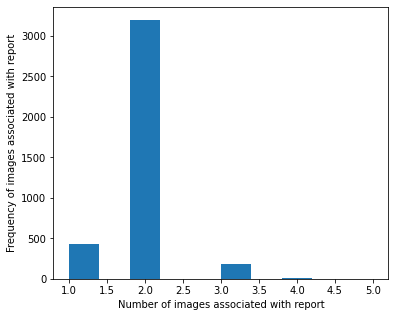

In [ ]:
img_count = list(data_dropped_nans.uid.value_counts())

print("Images per patient :\n")
print(pd.Series(img_count).value_counts())


plt.figure(figsize = (6,5))
pd.Series(img_count).plot(kind='hist')
plt.xlabel('Number of images associated with report')
plt.ylabel("Frequency of images associated with report")
plt.show()

In [ ]:
from PIL import Image

In [ ]:
def show_image_captions(df, patient_nr):
    new_df = data_dropped_nans[data_dropped_nans["uid"] == patient_nr]
    print("Findings :",df['findings'][patient_nr])
    print("Impressions :",df['impression'][patient_nr])
    print("Caption :",df['caption'][patient_nr])
    
    root_dir = '/datasets/gdrive/XRay-AKAKI/images_normalized/'
    fig, axs = plt.subplots(1, len(new_df), figsize = (10,10), tight_layout=True)

    for i in range(len(new_df)):
        if new_df['filename'].iloc[i][:len(str(patient_nr))] == str(patient_nr):
            img_id = new_df['filename'].iloc[i]
            img_path = root_dir + img_id
            image = Image.open(img_path)
            imgplot = axs[i].imshow(image)

    plt.show()

Findings : the cardiac silhouette and mediastinum size arein normal limits. there is no pulmonary edema. there is no focal consolidation. there are no of a pleural effusion. there is no evidence of pneumothorax
Impressions : normal chest
Caption : the cardiac silhouette and mediastinum size arein normal limits. there is no pulmonary edema. there is no focal consolidation. there are no of a pleural effusion. there is no evidence of pneumothorax. normal chest


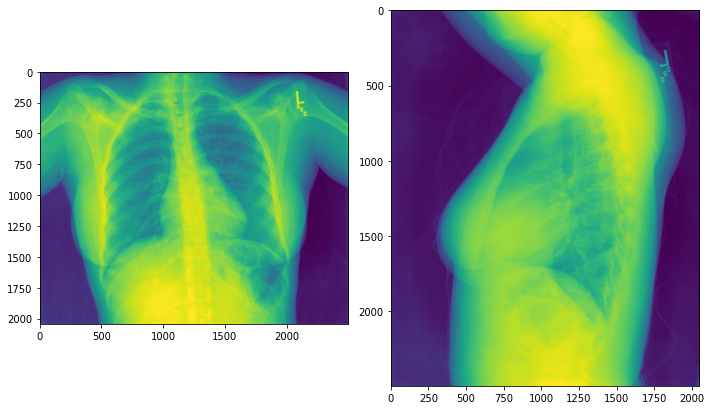

In [ ]:
show_image_captions(data_dropped_nans, 1)

Findings : there is scattered calcified granulomas. the lungs are otherwise grossly clear. cardiac and mediastinal silhouettes are normal. pulmonary vasculature is normal. no pneumothorax or pleural effusion. no acute bony abnormality
Impressions : no acute cardiopulmonary abnormality
Caption : there is scattered calcified granulomas. the lungs are otherwise grossly clear. cardiac and mediastinal silhouettes are normal. pulmonary vasculature is normal. no pneumothorax or pleural effusion. no acute bony abnormality. no acute cardiopulmonary abnormality


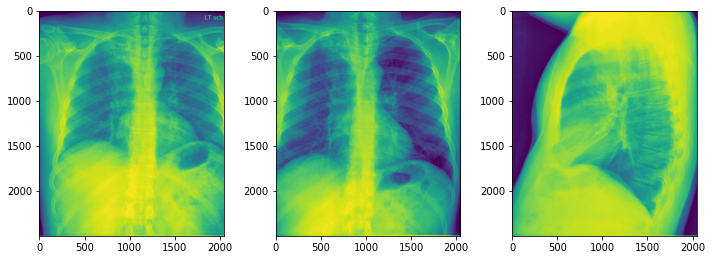

In [ ]:
show_image_captions(data_dropped_nans, 1000)

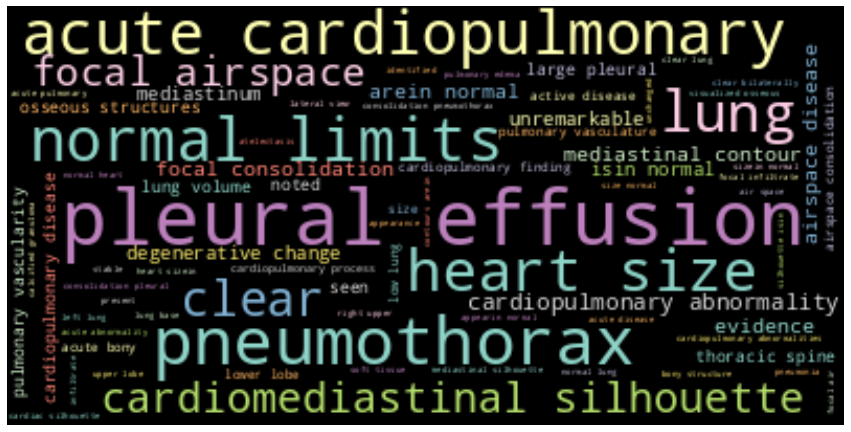

In [ ]:
#pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator

wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(data_dropped_nans['caption'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

**Preparing the dataset for computer vision task**

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
import tensorflow as tf

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
from tqdm import tqdm
import numpy as np

In [ ]:
# Get unique images
encode_train = sorted(set(images_file_names))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [ ]:
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/gdrive/XRay-AKAKI/images_normalized/1109_IM-0076-1001.dcm.png.npy'

---

## Modelling

### Computer Vision

### Natural Language Processing

### Machine Learning

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d67d5ca8-f99a-4baf-8748-4aa99efbd09b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>